In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path

In [3]:
train_path = Path("C://Users//vaish//archive//data//training_images//vid_4_600.jpg")
test_path = Path("C://Users//vaish//archive//data//testing_images//vid_5_400.jpg")

In [5]:
train = pd.read_csv("C://Users//vaish//archive//data//train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

In [6]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

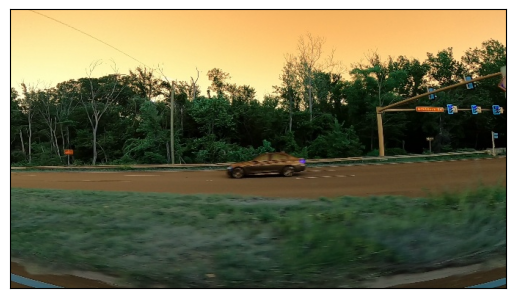

In [7]:
display_image_from_file("C://Users//vaish//archive//data//training_images//vid_4_600.jpg")

Error: Image data is None.
Error: Image data is None.
Error: Image data is None.


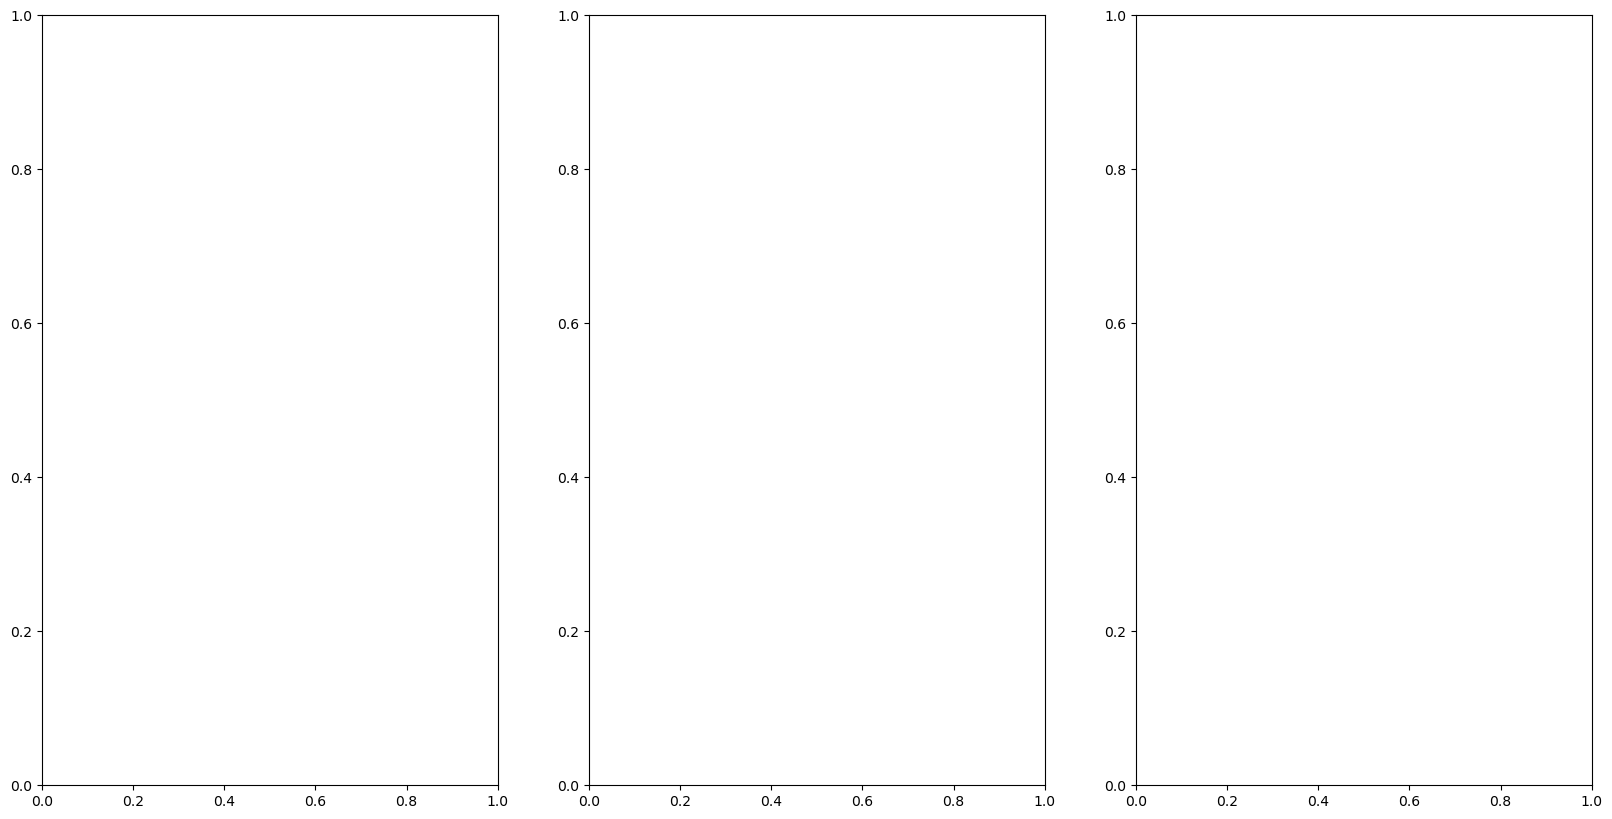

In [116]:
display_grid()

In [111]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}
        

In [ ]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

In [113]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 380, 676, 8)       224       
                                                                 
 batch_normalization_20 (Ba  (None, 380, 676, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 190, 338, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_21 (Ba  (None, 190, 338, 16)      64  

In [114]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [115]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

In [ ]:
import pandas as pd

# Assuming you have a DataFrame named df
df = pd.DataFrame({
    'image': ["C://Users//vaish//archive//data//testing_images//vid_5_25180.jpg", ...],  # Add more image names as needed
    'xmin': [10, ...],  # Add actual values
    'ymin': [20, ...],
    'xmax': [100, ...],
    'ymax': [150, ...],
})

# Now you can call the test function
test(model, df, "C://Users//vaish//archive//data//testing_images//vid_5_25200.jpg")


In [ ]:
test(model)

In [104]:
def data_generator(df, batch_size, path=train_path):
    num_batches = len(df) // batch_size

    for _ in range(num_batches):
        images = np.zeros((batch_size, image_size, image_size, 3), dtype=np.float32)
        bounding_box_coords = np.zeros((batch_size, 4), dtype=np.float32)

        for i in range(batch_size):
            rand_index = np.random.randint(0, len(df))
            row = df.iloc[rand_index, :]
            image_path = str(train_path / row.image)

            print(f"Reading image: {image_path}")

            # Read the image
            img = cv2.imread(image_path)

            if img is None:
                print(f"Warning: Unable to read image: {image_path}")
                # Handle the case where the image is not read successfully
                continue

            # Normalize the image
            images[i] = img / 255.
            bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}


In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

In [106]:
model.save('car-object-detection.h5')

In [107]:
def data_generator(df, batch_size, path):
    # Your implementation here
    # Make sure to use df, batch_size, and path as arguments
    pass


In [ ]:
_ = model.fit(
    data_generator(df=your_dataframe, batch_size=32, path="C://Users//vaish//archive//data//testing_images//vid_5_400.jpg"),
    epochs=9,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
    ]
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


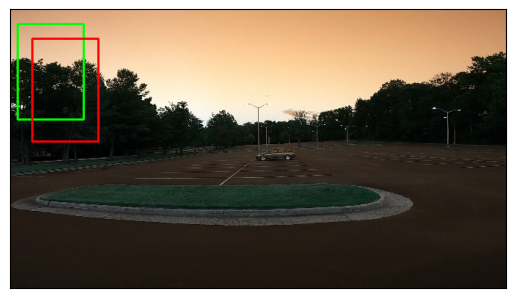

In [60]:
# Assuming 'img' is the image data loaded using cv2.imread()
img = cv2.imread("C://Users//vaish//archive//data//testing_images//vid_5_400.jpg")

# Placeholder bounding box coordinates
bbox_coords = [(10, 20, 100, 150)]  # Example values
pred_coords = [(30, 40, 120, 180)]  # Example values

# Example usage
display_image(img, bbox_coords=bbox_coords, pred_coords=pred_coords)


In [ ]:
def data_generator(df, batch_size, path):
    while True:
        images = np.zeros((batch_size, image_size, image_size, 3), dtype=np.float32)
        bounding_box_coords = np.zeros((batch_size, 4), dtype=np.float32)

        for i in range(batch_size):
            rand_index = np.random.randint(0, df.shape[0])
            row = df.loc[rand_index, :]
            image = cv2.imread(str(path / row.image)) / 255.0  # Normalize image
            images[i] = cv2.resize(image, (image_size, image_size))
            bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}

# Example usage
test(model, df, "C://Users//vaish//archive//data//testing_images//vid_5_25200.jpg")
